In [1]:
%matplotlib inline
from ipywidgets import *
import numpy as np
import k3d
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, brentq, minimize
from sloppy.optic import *
from sloppy.raytracing import *
from sloppy.abcd import *
from sloppy.utils import *
from sloppy.tools import *

In [2]:
from scipy.integrate import solve_ivp

In [3]:
class ThinLens(ABCD):
    def __init__(self, f):
        self.f = f
        m = np.identity(4)
        m[2,0] = -1./f
        m[3,1] = -1./f
        self.m = m
        
class CurvedMirror(ABCD):
    def __init__(self, R):
        self.R = R
        m = np.identity(4)
        m[2,0] = -2./R
        m[3,1] = -2./R
        self.m = m

## Properties of the GRIN lens and effective focal length

In [4]:
g = 0.362 # gradient constant
n0 = 1.624 # central index of refraction
d = 1.8 #diameter
z1p = (2*np.pi)/g # z 1 period
zl = 3.96
f = 1/(n0*g*np.sin(g*zl)) # focal length
s = 1/(n0*g*np.tan(g*zl)) # working distance
P = zl/z1p
NA = n0*np.sqrt(1 - (1/np.cosh((g*d)/2))**2)

In [7]:
print(f"Working distance {s:.3f} mm")
print(f"Focal length {f:.3f} mm")
print(f"Pitch {P:.3f}")
print(f"NA {NA:.3f}")

Working distance 0.235 mm
Focal length 1.717 mm
Pitch 0.228
NA 0.511


In [8]:
def n(x):
    return n0/np.cosh(g*x)

def dn(x):
    return -(g*n0/np.cosh(g*x)*np.tanh(g*x))

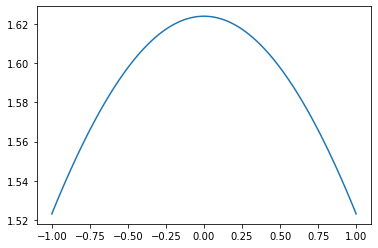

In [9]:
x = np.linspace(-1, 1, 100)
plt.figure()
plt.plot(x, n(x))
#plt.plot(x, dn(x))

In [10]:
def fun(t, y):
    x, u = y
    return [u, n(x)*dn(x)]

In [11]:
zrange = 20
Npts = 500
zs = np.linspace(0, zrange, Npts)
sol = solve_ivp(fun, [0, zrange], [0, 0.2], t_eval=zs)

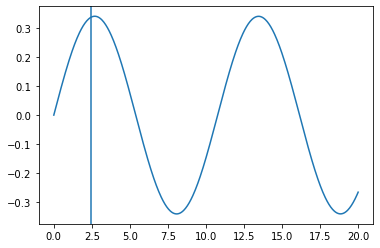

In [12]:
plt.figure()
plt.plot(sol['t'], sol['y'][0])
plt.axvline(zl/n0)

In [74]:
def _waists_vs_param(cavfct, parname, scanrange, N=300, degmodenum=1, s=1):
    stab = lambda m: abs(0.5*np.trace(m))<1
    La = inspect.signature(cavfct).parameters[parname].default
    if isinstance(scanrange, tuple):
        Las = np.linspace(scanrange[0], scanrange[1], N)
    else:
        Las = La + np.linspace(-scanrange*La, scanrange*La, N)
    ms = np.zeros((N))
    ws = np.zeros((N,2))
    freqs = np.zeros((N,4))
    for i, l in enumerate(Las):
        pardct = {parname: l}
        try:
            system = ABCDSystem(cavfct(**pardct))
            w = system.waist_at(0)
            if np.any(np.abs(w)*1e3 > 10):
                w[:] = np.nan
        except:
            ws[i,:] = np.nan
            ms[i] = np.nan
            freqs[i,...] = np.nan
        else:
            ms[i] = stab(system.abcd_rt)
            ws[i,:] = np.sort(w)
            freqs[i,...] = np.concatenate(system.get_freqs(s=s))

    # find the degeneracy condition: smallest s-fold transverse mode splitting with a stable mode
    degIdx=1+degmodenum
    #stable_mode_mask = [all(wpair>0) for wpair in ws]
    #subset_idx = np.argmin(np.abs(freqs[:,degIdx][stable_mode_mask]))
    #idx = np.arange(np.abs(freqs[:,degIdx]).shape[0])[stable_mode_mask][subset_idx] 
    idx = np.argmin(np.abs(freqs[:,degIdx]))
    
    g, ax = plt.subplots(ncols=2, figsize=(8,4), sharex=True)
    ax[0].plot(Las, ws*1e3)
    ax[0].set_ylabel('um')
    ax[1].plot(Las, freqs*1e-6)
    ax[1].set_ylabel('MHz')
    #ax[1].axhline(0, color='grey')
    #ax[0].axvline(Las[idx], color='grey')
    #ax[1].axvline(Las[idx], color='grey')
    #plt.show()
    Ldeg = Las[idx]
    return Ldeg, ax, ws, freqs, ms

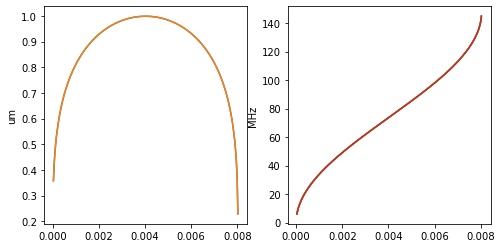

No handles with labels found to put in legend.


In [30]:
def grin_cavity_two(eps = 0.02, d1=5.0, d2=500.0):
    g = 0.362 # gradient constant
    n0 = 1.624 # central index of refraction
    d = 1.8 #diameter
    z1p = (2*np.pi)/g # z 1 period
    zl = 3.96
    f = 1/(n0*g*np.sin(g*zl)) # focal length
    f=2.0
    s = 1/(n0*g*np.tan(g*zl)) # working distance
    P = zl/z1p
    NA = n0*np.sqrt(1 - (1/np.cosh((g*d)/2))**2)
    #return [Prop(d1), ThinLens(f), Prop(2*f+eps), ThinLens(f), Prop(2*(d2-eps)), ThinLens(f), Prop(2*f+eps),ThinLens(f), Prop(d1)]
    return [Prop(f+eps), ThinLens(f), Prop(2*(d2-eps)), ThinLens(f), Prop(2*f+eps),ThinLens(f), Prop(2*d1), ThinLens(f), Prop(f)]

_, ax, ws, fs, ms = _waists_vs_param(grin_cavity_two, 'eps', (0.0, 0.01), s=1)
ax[1].legend()

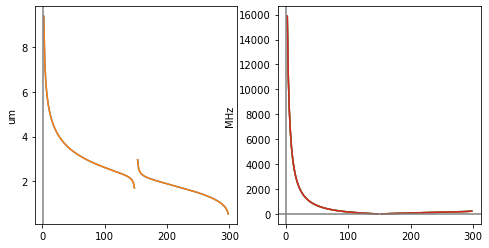

1.0

In [129]:
_waists_vs_param(grin_cavity_2, 'dprop', (1, 500.0), s=1)

C:\Users\simonlab\.conda\envs\sloppy\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
C:\Users\simonlab\.conda\envs\sloppy\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
c:\users\simonlab\documents\lukas\03_theory\abcd\sloppy\src\sloppy\abcd.py:154: RuntimeWarning: invalid value encountered in matmul
  abcd=ele.m@abcd
c:\users\simonlab\documents\lukas\03_theory\abcd\sloppy\src\sloppy\abcd.py:152: RuntimeWarning: invalid value encountered in matmul
  abcd=ele.m@abcd
c:\users\simonlab\documents\lukas\03_theory\abcd\sloppy\src\sloppy\abcd.py:243: RuntimeWarning: invalid value encountered in sqrt
  ws = np.sqrt(lam/(-n*np.pi)*((1/di.imag) if all(di.imag!=0) else np.array([np.nan, np.nan])))


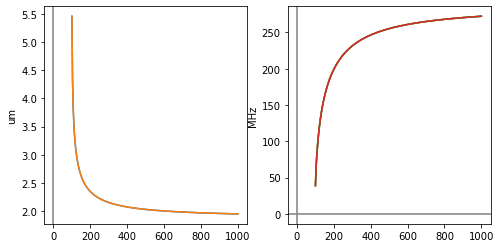

0.0

In [45]:
_waists_vs_param(grin_cavity_2, 'Rmirr', (0, 1000.0), s=1)

c:\users\simonlab\documents\lukas\03_theory\abcd\sloppy\src\sloppy\abcd.py:243: RuntimeWarning: invalid value encountered in sqrt
  ws = np.sqrt(lam/(-n*np.pi)*((1/di.imag) if all(di.imag!=0) else np.array([np.nan, np.nan])))


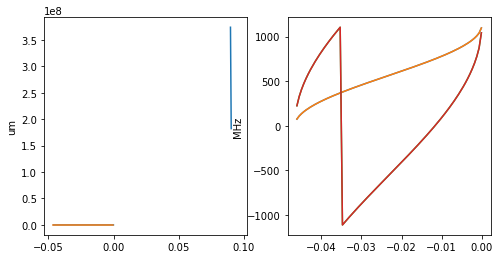

(0.0, 10.0)

In [32]:
def grin_cavity_running(eps = -0.02, dprop = 130.0):
    g = 0.362 # gradient constant
    n0 = 1.624 # central index of refraction
    d = 1.8 #diameter
    z1p = (2*np.pi)/g # z 1 period
    zl = 3.96
    f = 1/(n0*g*np.sin(g*zl)) # focal length
    s = 1/(n0*g*np.tan(g*zl)) # working distance
    P = zl/z1p
    NA = n0*np.sqrt(1 - (1/np.cosh((g*d)/2))**2)
    return [Prop(f-eps), ThinLens(f), Prop(dprop+2*eps), ThinLens(f), Prop(f-eps)]

_, ax,_,_,_ = _waists_vs_param(grin_cavity_running, 'eps', (-0.07, 0.1), s=3)
ax[0].set_ylim(0, 10)

c:\users\simonlab\documents\lukas\03_theory\abcd\sloppy\src\sloppy\abcd.py:243: RuntimeWarning: invalid value encountered in sqrt
  ws = np.sqrt(lam/(-n*np.pi)*((1/di.imag) if all(di.imag!=0) else np.array([np.nan, np.nan])))


Text(0.5, 1.0, '1429.2 nm')

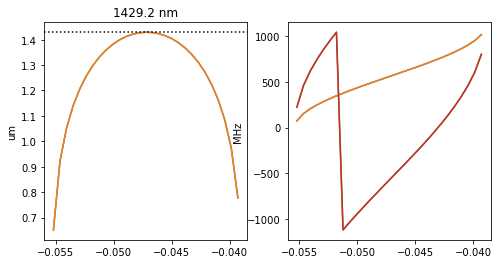

In [80]:
def grin_cavity_twist_cx(eps = -0.02, dprop = 130.0, dup=50.0, Rup = -75.0):
    g = 0.362 # gradient constant
    n0 = 1.624 # central index of refraction
    d = 1.8 #diameter
    z1p = (2*np.pi)/g # z 1 period
    zl = 3.96
    f = 1/(n0*g*np.sin(g*zl)) # focal length
    s = 1/(n0*g*np.tan(g*zl)) # working distance
    P = zl/z1p
    NA = n0*np.sqrt(1 - (1/np.cosh((g*d)/2))**2)
    return [Prop(f-eps), ThinLens(f), Prop(dprop/2-dup/2+eps), CurvedMirror(Rup), Prop(dup), CurvedMirror(Rup), Prop(dprop/2-dup/2+eps), ThinLens(f), Prop(f-eps)]

_, ax,ws,_,_ = _waists_vs_param(grin_cavity_twist_cx, 'eps', (-0.07, 0.1), s=3)
w0 = np.nanmax(ws)
ax[0].axhline(w0*1e3, color='k', ls=':')
ax[0].set_title(f"{(w0*1e6):.1f} nm")
#ax[0].set_ylim(0, 1)

Text(0.5, 1.0, '606.6 nm')

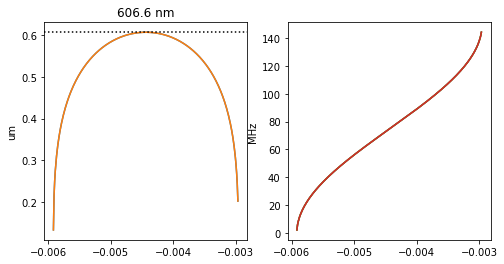

In [76]:
def grin_cavity_3(eps = -0.02, dprop = 500.0, Rmirr = -500):
    g = 0.362 # gradient constant
    n0 = 1.624 # central index of refraction
    d = 1.8 #diameter
    z1p = (2*np.pi)/g # z 1 period
    zl = 3.96
    f = 1/(n0*g*np.sin(g*zl)) # focal length
    s = 1/(n0*g*np.tan(g*zl)) # working distance
    P = zl/z1p
    NA = n0*np.sqrt(1 - (1/np.cosh((g*d)/2))**2)
    return [Prop(f-eps), ThinLens(f), Prop(dprop+eps), CurvedMirror(Rmirr), Prop(dprop+eps), ThinLens(f), Prop(f-eps)]

_, ax,ws,_,_ = _waists_vs_param(grin_cavity_3, 'eps', (-0.01, 0.0), s=1, N=1000)
w0 = np.nanmax(ws)
ax[0].axhline(w0*1e3, color='k', ls=':')
ax[0].set_title(f"{(w0*1e6):.1f} nm")
#ax[0].set_ylim(0, 1)

## Mode matching

In [21]:
q_w = abcd_cav.q_at(0.0)

In [47]:
d_im = 10-2 #11.0
f_im = 11.0 
elemets_im = [Prop(d_im), ThinLens(f_im), Prop(100.0)]
abcd_im = ABCDSystem(elemets_im)

In [115]:
ng = 1.517 # fused silica 1.4537
d_mirr = 4.0
#C240TMD-B (EFL 8.0mm)
nl = 1.517 # BK7  
# d_lens = 3.43
# R_lens = 4.638124 #(https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=3811)

#C220TMD-B (EFL 11.0mm)
# nl = 1.517 # BK7  
# d_lens = 5.0
# R_lens = 6.428132 #(https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=3811)

# LA4647-B
d_lens = 4.3
R_lens = 9.2 #https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=6532&pn=LA4647-B#6533 

d_im = 20.0-d_mirr #8.35-1.1-1 #8.35#from mirror back face to end of small optics adapter

elemets_im = [ABCD(Glass(n2=ng).m), Prop(d_mirr, n=ng), ABCD(Glass(n1=ng).m), Prop(d_im),\
                ABCD(Glass(n2=ng).m), Prop(d_lens, n=ng),  ABCD(CurvedGlass(R=-R_lens, curv='CC', n1=ng).m),\
                   Prop(50.0)]
abcd_im = ABCDSystem(elemets_im)

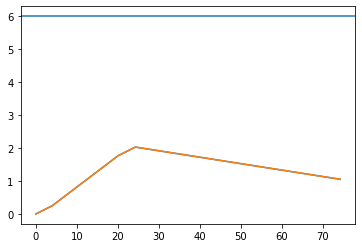

In [116]:
x_im = np.linspace(0, abcd_im.Ltot, 500)
ws_im = abcd_im.compute_waists(x_im, qin=q_w)
plt.figure()
plt.plot(x_im, ws_im)
plt.axhline(6.0)
plt.show()

In [106]:
q_in = abcd_cav.q_at(abcd_cav.Ltot/2) 

In [46]:
d_mm = 10.0-2
f_mm = 11.0 
elemets_mm = [Prop(d_mm), ThinLens(f_mm), Prop(100.0)]
abcd_mm = ABCDSystem(elemets_mm)